In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CS5344_diagram

/content/drive/.shortcut-targets-by-id/1qv98RuFSnwoCbo22L7F1IsVtbRQ9esTo/CS5344_diagram


# 1. Import the necessary library

In [ ]:
import networkx as nx
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
%matplotlib inline
plt.style.use('seaborn')
# enabling outlines line in histogram
plt.rcParams["patch.force_edgecolor"] = True
from networkx.algorithms.community.quality import coverage, modularity
import re # for regular expressions
pd.set_option("display.max_colwidth", 200)
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
from textblob import Word
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
sns.set_style("whitegrid", {'axes.grid' : False})
import random
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm
import spacy
from spacy.util import compounding
from spacy.util import minibatch


# 2. Read diagram

In [ ]:
vax_dig = nx.read_gml('/content/drive/MyDrive/CS5344_diagram/graph_reply/sin1/Final_DiGraph_sentiment_Vax.gml')

In [ ]:
data = list(vax_dig.nodes.data())

In [ ]:
data[0]

('rtolarz',
 {'sentiment': 0.0,
  'sentimentComm': 1,
  'tweet': '#aşı #AsıYanetki #asımağdurları #ZorunluAsıyaHayır #BioNTechpfizer #Biontech #sinovac #sinovacvaccine #mRNA  https://t.co/nNc7azPcLU'})

In [ ]:
tweet = []
for i in data:
  if('tweet' in i[1]):
    tweet.append(i[1]['tweet'])

In [ ]:
com = []
for i in data:
  if('tweet' in i[1]):
    com.append(i[1]['sentimentComm'])

In [ ]:
tweet_df = pd.DataFrame(tweet, columns=['Text'])
com_df = pd.DataFrame(com, columns=['Com'])
final = pd.concat([tweet_df,com_df], axis=1)

In [ ]:
final2=final.copy()

# 3. Perofrm data cleaning

In [ ]:
import string

import nltk
from nltk.corpus import stopwords
from nltk import re

MIN_YEAR = 1900
MAX_YEAR = 2100


def get_url_patern():
    return re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'
        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')


def get_emojis_pattern():
    try:
        # UCS-4
        emojis_pattern = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    except re.error:
        # UCS-2
        emojis_pattern = re.compile(
            u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])')
    return emojis_pattern


def get_hashtags_pattern():
    return re.compile(r'#\w*')


def get_single_letter_words_pattern():
    return re.compile(r'(?<![\w\-])\w(?![\w\-])')


def get_blank_spaces_pattern():
    return re.compile(r'\s{2,}|\t')


def get_twitter_reserved_words_pattern():
    return re.compile(r'(RT|rt|FAV|fav|VIA|via)')


def get_mentions_pattern():
    return re.compile(r'@\w*')


def is_year(text):
    if (len(text) == 3 or len(text) == 4) and (MIN_YEAR < len(text) < MAX_YEAR):
        return True
    else:
        return False


class TwitterPreprocessor:

    def __init__(self, text: str):
        self.text = text

    def fully_preprocess(self):
        return self \
            .remove_urls() \
            .remove_mentions() \
            .remove_hashtags() \
            .remove_twitter_reserved_words() \
            .remove_punctuation() \
            .remove_single_letter_words() \
            .remove_blank_spaces() \
            .remove_stopwords() \
            .remove_numbers()

    def remove_urls(self):
        self.text = re.sub(pattern=get_url_patern(), repl='', string=self.text)
        return self

    def remove_punctuation(self):
        self.text = re.sub(r'[^\w\s\d]', '', self.text)
        return self

    def remove_mentions(self):
        self.text = re.sub(pattern=get_mentions_pattern(), repl='', string=self.text)
        return self

    def remove_hashtags(self):
        self.text = re.sub(pattern=get_hashtags_pattern(), repl='', string=self.text)
        return self

    def remove_twitter_reserved_words(self):
        self.text = re.sub(pattern=get_twitter_reserved_words_pattern(), repl='', string=self.text)
        return self

    def remove_single_letter_words(self):
        self.text = re.sub(pattern=get_single_letter_words_pattern(), repl='', string=self.text)
        return self

    def remove_blank_spaces(self):
        self.text = re.sub(pattern=get_blank_spaces_pattern(), repl=' ', string=self.text)
        return self

    def remove_stopwords(self, extra_stopwords=None):
        if extra_stopwords is None:
            extra_stopwords = []
        text = nltk.word_tokenize(self.text)
        stop_words = set(stopwords.words('english'))

        new_sentence = []
        for w in text:
            if w not in stop_words and w not in extra_stopwords:
                new_sentence.append(w)
        self.text = ' '.join(new_sentence)
        return self

    def remove_numbers(self, preserve_years=False):
        text_list = self.text.split(' ')
        for text in text_list:
            if text.isnumeric():
                if preserve_years:
                    if not is_year(text):
                        text_list.remove(text)
                else:
                    text_list.remove(text)

        self.text = ' '.join(text_list)
        return self

    def lowercase(self):
        self.text = self.text.lower()
        return self
    
    def lemmatization(self):
      nltk.download('wordnet')
      self.text= self.text.apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
    

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Clean tweets and append to new column
tweets = final['Text']
clean_tweets = []
for tweet in tweets:
    c = TwitterPreprocessor((tweet))
    c.fully_preprocess()
    c = c.text
    clean_tweets.append(c)
    
final['clean_Text'] = clean_tweets 
final.head(5)

,Text,Com,clean_Text
0,#aşı #AsıYanetki #asımağdurları #ZorunluAsıyaHayır #BioNTechpfizer #Biontech #sinovac #sinovacvaccine #mRNA https://t.co/nNc7azPcLU,1,
1,"Sinovac Vaccine Falls Short of Expectations, But Options Limited https://t.co/cm7o73LzQC",1,Sinovac Vaccine Falls Sho Expectations But Options Limited
2,"@bkkaussie @latikambourke Many Thai doctors are now calling for an end to Sinovac (no proven immunity to Delta, Beta strains) &amp; call on the gov’t to focus on the mRNA vaccines.",0,Many Thai doctors calling end Sinovac proven immunity Delta Beta strains amp call govt focus mRNA vaccines
3,NEW WHO calls on countries exempting vaccinated travellers to recognise all WHO-approved jabs. Significant implications for Australians jabbed abroad with non-TGA approved vaccines like China's...,0,NEW WHO calls countries exempting vaccinated travellers recognise WHOapproved jabs Significant implications Australians jabbed abroad nonTGA approved vaccines like Chinas Sinopharm Sinovac
4,"@DOHgovph Hello, good morning. Is it possible to have different brands of vaccine na ituturok? Like Sinovac 1st dose, and 2nd dose is another brand? Considering that person is in another LGU for 2...",1,Hello good morning Is possible different brands vaccine na ituturok Like Sinovac 1st dose 2nd dose another brand Considering person another LGU 2nd dose available vaccine Sinovac


In [ ]:
final['clean_Text'] = final['clean_Text'].apply(lambda x: re.sub('[^A-Za-z0-9\s]+','', x))

In [ ]:
final

,Text,Com,clean_Text
0,#aşı #AsıYanetki #asımağdurları #ZorunluAsıyaHayır #BioNTechpfizer #Biontech #sinovac #sinovacvaccine #mRNA https://t.co/nNc7azPcLU,1,
1,"Sinovac Vaccine Falls Short of Expectations, But Options Limited https://t.co/cm7o73LzQC",1,Sinovac Vaccine Falls Sho Expectations But Options Limited
2,"@bkkaussie @latikambourke Many Thai doctors are now calling for an end to Sinovac (no proven immunity to Delta, Beta strains) &amp; call on the gov’t to focus on the mRNA vaccines.",0,Many Thai doctors calling end Sinovac proven immunity Delta Beta strains amp call govt focus mRNA vaccines
3,NEW WHO calls on countries exempting vaccinated travellers to recognise all WHO-approved jabs. Significant implications for Australians jabbed abroad with non-TGA approved vaccines like China's...,0,NEW WHO calls countries exempting vaccinated travellers recognise WHOapproved jabs Significant implications Australians jabbed abroad nonTGA approved vaccines like Chinas Sinopharm Sinovac
4,"@DOHgovph Hello, good morning. Is it possible to have different brands of vaccine na ituturok? Like Sinovac 1st dose, and 2nd dose is another brand? Considering that person is in another LGU for 2...",1,Hello good morning Is possible different brands vaccine na ituturok Like Sinovac 1st dose 2nd dose another brand Considering person another LGU 2nd dose available vaccine Sinovac
...,...,...,...
4803,"Chareluck Santos, Head Nurse of UP Health Service, says she is proud to have been chosen as the vaccinator of PGH Director Gap Legaspi, the first PGH employee to receive CoronaVac (Sinovac) vaccin...",1,Chareluck Santos Head Nurse UP Health Service says proud chosen vaccinator PGH Director Gap Legaspi first PGH employee receive CoronaVac Sinovac vaccine She considers sta vaccination country historic
4804,"If SINOVAC is unsafe then why there are 17 countries who purchased and trust the CHINESE VACCINE. Therefore the Vaccine is not the problem, the problem here are the peoples mind who insisted that...",1,If SINOVAC unsafe countries purchased trust CHINESE VACCINE Therefore Vaccine problem problem peoples mind insisted vaccine safe
4805,Paalala ko lang Sinovac din ginamit ni Pres Widodo. Presidente yan ha pero hindi naginarte kagaya nyo. Social justice warrior daw pero gusto ng special treatment sa vaccine. Char 😂,1,Paalala ko lang Sinovac din ginamit ni Pres Widodo Presidente yan ha pero hindi naginae kagaya nyo Social justice warrior daw pero gusto ng special treatment sa vaccine Char
4806,"US doubting the 74% efficacy of J&amp;J COVID-19 vaccine while Philippines welcoming the 50% something efficacy of Sinovac, says so many about the Philippine government under the dictatorship of D...",1,US doubting efficacy JampJ COVID19 vaccine Philippines welcoming something efficacy Sinovac says many Philippine government dictatorship Dutee


# 4. Divide into two Community

In [ ]:
#Group1
Com1_all = final[final['Com']==0]
#Group2
Com2_all = final[final['Com']==1]

# 5. Comunity1

In [ ]:
Com1_all.head()

,Text,Com,clean_Text
2,"@bkkaussie @latikambourke Many Thai doctors are now calling for an end to Sinovac (no proven immunity to Delta, Beta strains) &amp; call on the gov’t to focus on the mRNA vaccines.",0,Many Thai doctors calling end Sinovac proven immunity Delta Beta strains amp call govt focus mRNA vaccines
3,NEW WHO calls on countries exempting vaccinated travellers to recognise all WHO-approved jabs. Significant implications for Australians jabbed abroad with non-TGA approved vaccines like China's...,0,NEW WHO calls countries exempting vaccinated travellers recognise WHOapproved jabs Significant implications Australians jabbed abroad nonTGA approved vaccines like Chinas Sinopharm Sinovac
6,@T13 Chinos qlos🖕🖕 y su cagah de #ChantaVac 🇨🇳🇨🇳 compren más Pfizer los wns @GobiernodeChile y liquiden esa weaa de #sinovacvaccine pah otro pais,0,Chinos qlos su cagah de compren ms Pfizer los wns liquiden esa weaa de pah otro pais
11,"@deomacalmaRH Dumating na kahapon ang 600,000 Sinovac #COVID19 vaccines na donasyon ng China. Hudyat ito ng mass vaccination sa bansa na sisimulan ngayong araw. | via RH30 @liezel_once #FactsNFigu...",0,Dumating na kahapon ang Sinovac vaccines na donasyon ng China Hudyat ito ng mass vaccination sa bansa na sisimulan ngayong araw RH30 WATCH
12,"@thinking_manc @Swen_2017 @Semyaza666 @MarbleMenno @BoukjevdBerg @vonderleyen Astrazeneca vaccine is not even the cheapest out there. You have CanSino (single dose), Sinovac, indian Covaxin, proba...",0,Astrazeneca vaccine even cheapest You CanSino single dose Sinovac indian Covaxin probably soon Soberana2 Abdala MadisaCuban vaccines


In [ ]:
Com1 = Com1_all.drop(columns=['Text'])

## 5.1 Perform TF-IDF for each word

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def TF_IDF(Y):
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(Y['clean_Text'])
  feature_names = vectorizer.get_feature_names()
  dense = X.todense()
  list1 = dense.tolist()
  df = pd.DataFrame(list1, columns=feature_names)
  df2 = pd.DataFrame(df.T.sum(axis=1),columns=['weight'])
  df3 = df2.sort_values(by=['weight'],ascending=False)
  return df3

In [ ]:
df_com1 = TF_IDF(Com1)

In [ ]:
df_com1.head()

,weight
vaccine,100.270052
sinovac,94.480823
vaccines,63.485115
covid19,44.085758
ng,39.627885


In [ ]:
df_com1.reset_index(level=0, inplace=True)

In [ ]:
df_com1.head(5)

,index,weight
0,vaccine,100.270052
1,sinovac,94.480823
2,vaccines,63.485115
3,covid19,44.085758
4,ng,39.627885


In [ ]:
df_com1.columns=['Word','Weight']

In [ ]:
df_com1.head()

,Word,Weight
0,vaccine,100.270052
1,sinovac,94.480823
2,vaccines,63.485115
3,covid19,44.085758
4,ng,39.627885


## 5.2 Sentiment Analysis for each word

In [ ]:
from textblob import TextBlob
def get_polarity(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
df_com1['Polarity'] = df_com1['Word'].apply(get_polarity)

In [ ]:
df_com1

,Word,Weight,Polarity
0,vaccine,100.270052,0.0
1,sinovac,94.480823,0.0
2,vaccines,63.485115,0.0
3,covid19,44.085758,0.0
4,ng,39.627885,0.0
...,...,...,...
7615,idhr,0.123761,0.0
7616,ye,0.123761,0.0
7617,multan,0.123761,0.0
7618,covidecia,0.123761,0.0


### 5.2.1 Sentiment for word

In [ ]:
df_com1['Sentiment_Type']=''
df_com1.loc[df_com1.Polarity>0,'Sentiment_Type']='POSITIVE'
df_com1.loc[df_com1.Polarity==0,'Sentiment_Type']='NEUTRAL'
df_com1.loc[df_com1.Polarity<0,'Sentiment_Type']='NEGATIVE'

In [ ]:
Pos = df_com1.loc[df_com1.Sentiment_Type=='POSITIVE'][0:100]
Neg = df_com1.loc[df_com1.Sentiment_Type=='NEGATIVE'][0:100]
Neu = df_com1.loc[df_com1.Sentiment_Type=='NEUTRAL'][1:101]

In [ ]:
Pos = Pos[['Word','Weight']]
Neg = Neg[['Word','Weight']]
Neu = Neu[['Word','Weight']]

In [ ]:
Pos.to_csv('/content/drive/MyDrive/CS5344_WordCloud/s1/mention/com1/pos.csv') 
Neg.to_csv('/content/drive/MyDrive/CS5344_WordCloud/s1/mention/com1/neg.csv') 
Neu.to_csv('//content/drive/MyDrive/CS5344_WordCloud/s1/mention/com1/neu.csv')

### 5.2.2 Sentiment for tweet

In [ ]:
Com1_all['Polarity'] = Com1_all['clean_Text'].apply(get_polarity)

In [ ]:
Com1_all['Sentiment_Type']=''
Com1_all.loc[Com1_all.Polarity>0,'Sentiment_Type']='POSITIVE'
Com1_all.loc[Com1_all.Polarity==0,'Sentiment_Type']='NEUTRAL'
Com1_all.loc[Com1_all.Polarity<0,'Sentiment_Type']='NEGATIVE'

## 5.3 Analyze the Polarity information

In [ ]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

### 5.3.1 For Word

In [ ]:
temp = df_com1.groupby('Sentiment_Type').count()['Word'].reset_index().sort_values(by='Word',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Sentiment_Type,Word
1,NEUTRAL,7237
2,POSITIVE,215
0,NEGATIVE,168


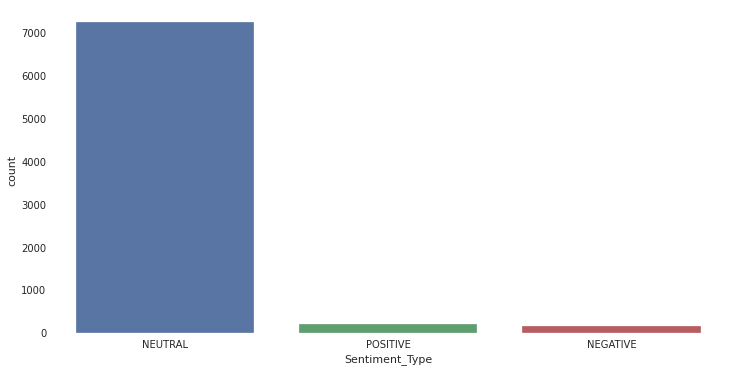

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment_Type',data=df_com1)

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.Sentiment_Type,
    values = temp.Word,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

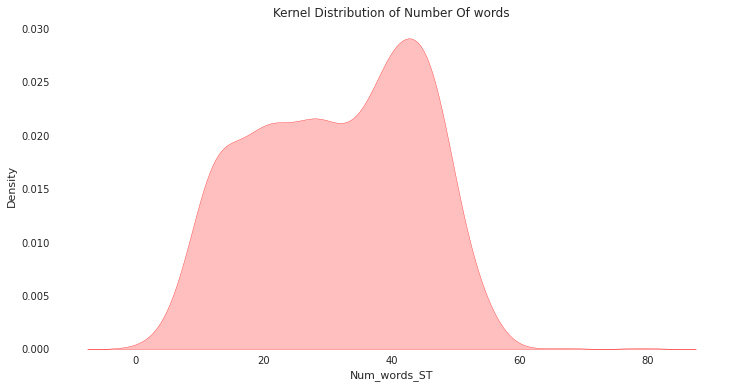

In [ ]:
df_com1['Num_words_ST'] = Com1_all['Text'].apply(lambda x:len(str(x).split()))
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df_com1['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')

In [ ]:
df2 = df_com1.copy()

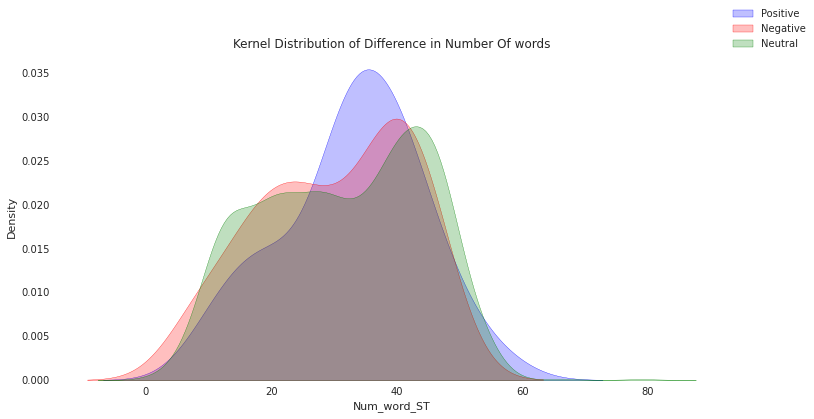

In [ ]:
df2.columns=['Word','Weight','Polarity','sentiment','Num_word_ST']
fig = plt.figure(figsize=(12,6))
p1=sns.kdeplot(df2[df2['sentiment']=='POSITIVE']['Num_word_ST'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(df2[df2['sentiment']=='NEGATIVE']['Num_word_ST'], shade=True, color="r")
p3=sns.kdeplot(df2[df2['sentiment']=='NEUTRAL']['Num_word_ST'], shade=True, color="g")
fig.legend(labels=["Positive",'Negative','Neutral'])

### 5.3.2 For tweet

In [ ]:
temp2 = Com1_all.groupby('Sentiment_Type').count()['clean_Text'].reset_index().sort_values(by='clean_Text',ascending=False)
temp2.style.background_gradient(cmap='Purples')

,Sentiment_Type,clean_Text
2,POSITIVE,869
1,NEUTRAL,772
0,NEGATIVE,306


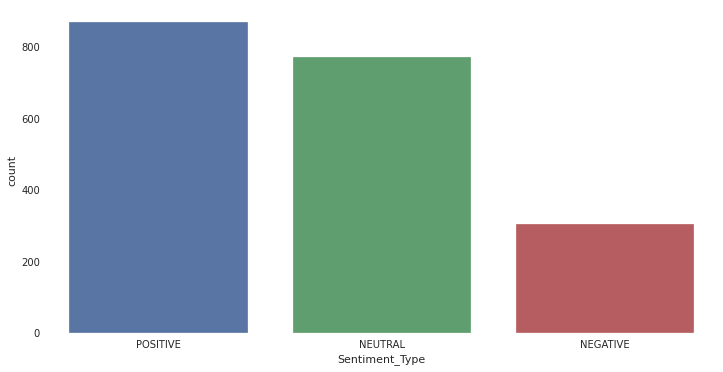

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment_Type',data=Com1_all)

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp2.Sentiment_Type,
    values = temp2.clean_Text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [ ]:
Com1_all2 = Com1_all.copy()

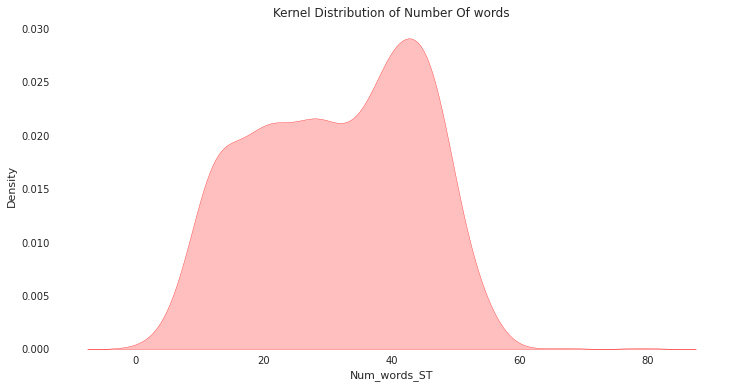

In [ ]:
Com1_all2['Num_words_ST'] = Com1_all['Text'].apply(lambda x:len(str(x).split()))
plt.figure(figsize=(12,6))
p1=sns.kdeplot(Com1_all2['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')

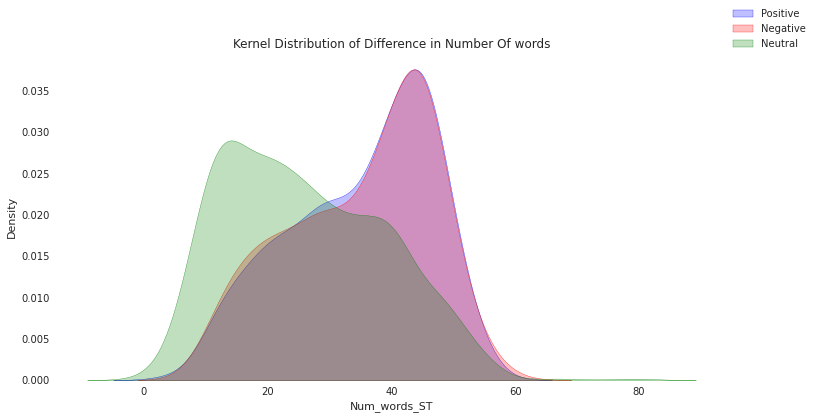

In [ ]:
Com1_all2.columns = ['Text','Com','clean_Text','Polarity','sentiment','Num_words_ST']
fig = plt.figure(figsize=(12,6))
p1=sns.kdeplot(Com1_all2[Com1_all2['sentiment']=='POSITIVE']['Num_words_ST'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(Com1_all2[Com1_all2['sentiment']=='NEGATIVE']['Num_words_ST'], shade=True, color="r")
p3=sns.kdeplot(Com1_all2[Com1_all2['sentiment']=='NEUTRAL']['Num_words_ST'], shade=True, color="g")
fig.legend(labels=["Positive",'Negative','Neutral'])

# 6. Community2

In [ ]:
Com2_all.head()

,Text,Com,clean_Text
0,#aşı #AsıYanetki #asımağdurları #ZorunluAsıyaHayır #BioNTechpfizer #Biontech #sinovac #sinovacvaccine #mRNA https://t.co/nNc7azPcLU,1,
1,"Sinovac Vaccine Falls Short of Expectations, But Options Limited https://t.co/cm7o73LzQC",1,Sinovac Vaccine Falls Sho Expectations But Options Limited
4,"@DOHgovph Hello, good morning. Is it possible to have different brands of vaccine na ituturok? Like Sinovac 1st dose, and 2nd dose is another brand? Considering that person is in another LGU for 2...",1,Hello good morning Is possible different brands vaccine na ituturok Like Sinovac 1st dose 2nd dose another brand Considering person another LGU 2nd dose available vaccine Sinovac
5,"HSA begins review of Sinovac Covid-19 vaccine for use in Singapore, asks Chinese firm for more data https://t.co/6kQjDauLhB",1,HSA begins review Sinovac Covid19 vaccine use Singapore asks Chinese firm data
7,"There were recent outbreaks in countries with high Sinopharm/Sinovac vaccination rates eg. Mongolia, Seychelles, Chile However there are too many variables that could account for this eg. *varian...",1,There recent outbreaks countries high SinopharmSinovac vaccination rates eg Mongolia Seychelles Chile However many variables could account eg variants ineffective PH measures etc nothing vaccine e...


In [ ]:
Com2 = Com2_all.drop(columns=['Text'])

## 6.1 Perform TF-IDF for each word

In [ ]:
df_com2 = TF_IDF(Com2)

In [ ]:
df_com2.head()

,weight
vaccine,169.880379
sinovac,160.978903
covid19,90.753122
vaccines,81.795176
chinas,67.884895


In [ ]:
df_com2.reset_index(level=0, inplace=True)
df_com2.head()

,index,weight
0,vaccine,169.880379
1,sinovac,160.978903
2,covid19,90.753122
3,vaccines,81.795176
4,chinas,67.884895


In [ ]:
df_com2.columns=['Word','Weight']
df_com2.head()

,Word,Weight
0,vaccine,169.880379
1,sinovac,160.978903
2,covid19,90.753122
3,vaccines,81.795176
4,chinas,67.884895


## 6.2 Sentiment Analysis for each word

In [ ]:
df_com2['Polarity'] = df_com2['Word'].apply(get_polarity)

In [ ]:
df_com2

,Word,Weight,Polarity
0,vaccine,169.880379,0.0
1,sinovac,160.978903,0.0
2,covid19,90.753122,0.0
3,vaccines,81.795176,0.0
4,chinas,67.884895,0.0
...,...,...,...
8326,xin,0.127708,0.0
8327,trnh,0.127708,0.0
8328,rahul,0.124692,0.0
8329,gandhi,0.124692,0.0


### 6.2.1 Sentiment for word

In [ ]:
df_com2['Sentiment_Type']=''
df_com2.loc[df_com2.Polarity>0,'Sentiment_Type']='POSITIVE'
df_com2.loc[df_com2.Polarity==0,'Sentiment_Type']='NEUTRAL'
df_com2.loc[df_com2.Polarity<0,'Sentiment_Type']='NEGATIVE'

In [ ]:
Pos2 = df_com2.loc[df_com2.Sentiment_Type=='POSITIVE'][0:100]
Neg2 = df_com2.loc[df_com2.Sentiment_Type=='NEGATIVE'][0:100]
Neu2 = df_com2.loc[df_com2.Sentiment_Type=='NEUTRAL'][1:101]

In [ ]:
Pos2 = Pos2[['Word','Weight']]
Neg2 = Neg2[['Word','Weight']]
Neu2 = Neu2[['Word','Weight']]

In [ ]:
Pos2.to_csv('/content/drive/MyDrive/CS5344_WordCloud/s1/mention/com2/pos.csv') 
Neg2.to_csv('/content/drive/MyDrive/CS5344_WordCloud/s1/mention/com2/neg.csv') 
Neu2.to_csv('/content/drive/MyDrive/CS5344_WordCloud/s1/mention/com2/neu.csv')

### 6.2.2 Sentiment for tweet

In [ ]:
Com2_all['Polarity'] = Com2_all['clean_Text'].apply(get_polarity)

In [ ]:
Com2_all['Sentiment_Type']=''
Com2_all.loc[Com2_all.Polarity>0,'Sentiment_Type']='POSITIVE'
Com2_all.loc[Com2_all.Polarity==0,'Sentiment_Type']='NEUTRAL'
Com2_all.loc[Com2_all.Polarity<0,'Sentiment_Type']='NEGATIVE'

## 6.3 Analyze the Polarity information

### 6.3.1 For Word

In [ ]:
temp = df_com2.groupby('Sentiment_Type').count()['Word'].reset_index().sort_values(by='Word',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Sentiment_Type,Word
1,NEUTRAL,7939
2,POSITIVE,220
0,NEGATIVE,172


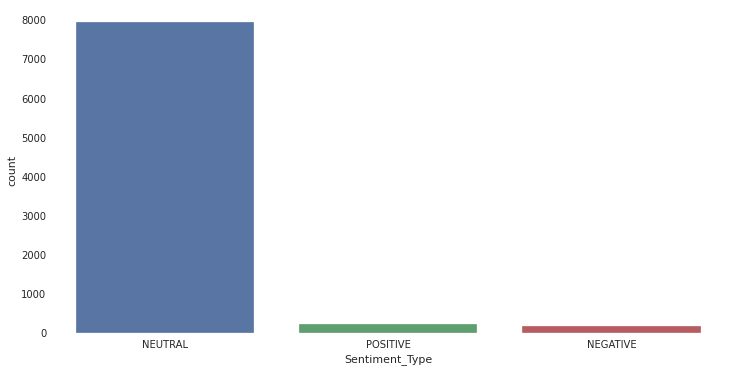

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment_Type',data=df_com2)

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.Sentiment_Type,
    values = temp.Word,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [ ]:
df_com2['Num_words_ST'] = Com2_all['Text'].apply(lambda x:len(str(x).split()))

In [ ]:
df2 = df_com2.copy()

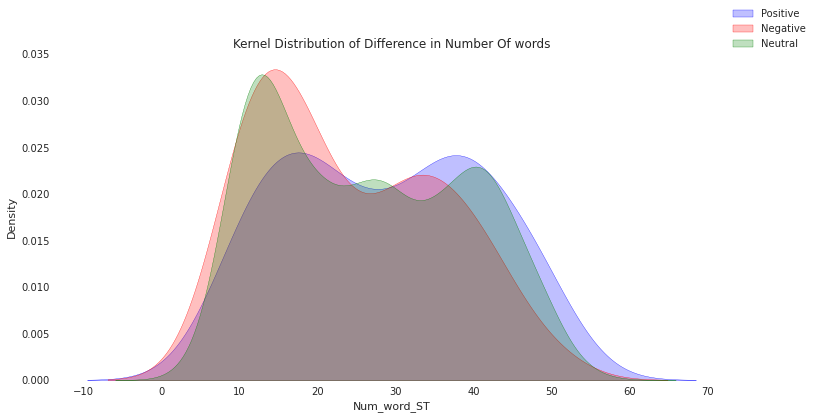

In [ ]:
df2.columns=['Word','Weight','Polarity','sentiment','Num_word_ST']
fig = plt.figure(figsize=(12,6))
p1=sns.kdeplot(df2[df2['sentiment']=='POSITIVE']['Num_word_ST'], shade=True, color="b",legend=True).set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(df2[df2['sentiment']=='NEGATIVE']['Num_word_ST'], shade=True, color="r",legend=True)
p3=sns.kdeplot(df2[df2['sentiment']=='NEUTRAL']['Num_word_ST'], shade=True, color="g",legend=True)
fig.legend(labels=["Positive",'Negative','Neutral'])

### 6.3.2 For tweet

In [ ]:
temp2 = Com2_all.groupby('Sentiment_Type').count()['clean_Text'].reset_index().sort_values(by='clean_Text',ascending=False)
temp2.style.background_gradient(cmap='Purples')

,Sentiment_Type,clean_Text
1,NEUTRAL,1361
2,POSITIVE,1166
0,NEGATIVE,334


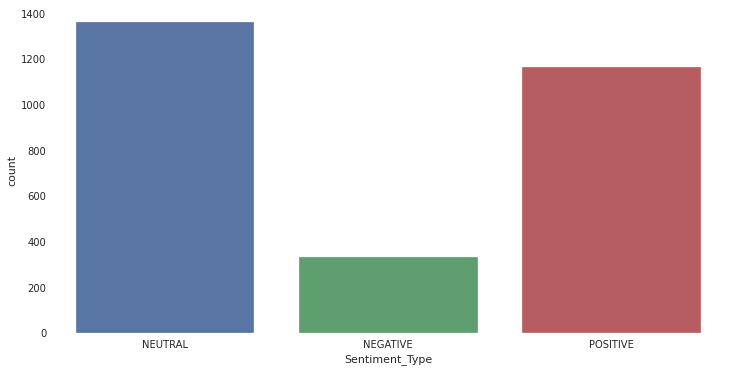

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment_Type',data=Com2_all)

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp2.Sentiment_Type,
    values = temp2.clean_Text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [ ]:
Com2_all2 = Com2_all.copy()

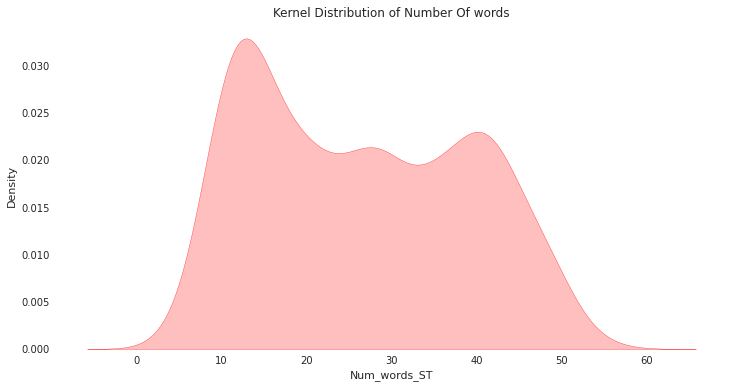

In [ ]:
Com2_all2['Num_words_ST'] = Com2_all['Text'].apply(lambda x:len(str(x).split()))
plt.figure(figsize=(12,6))
p1=sns.kdeplot(Com2_all2['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')

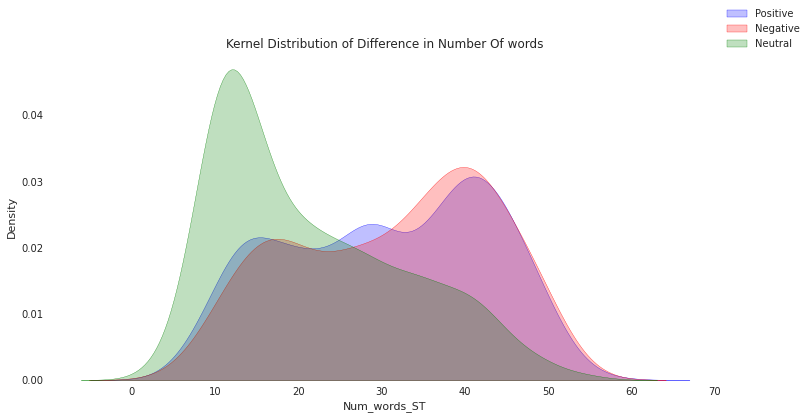

In [ ]:
Com2_all2.columns = ['Text','Com','clean_Text','Polarity','sentiment','Num_words_ST']
fig = plt.figure(figsize=(12,6))
p1=sns.kdeplot(Com2_all2[Com2_all2['sentiment']=='POSITIVE']['Num_words_ST'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(Com2_all2[Com2_all2['sentiment']=='NEGATIVE']['Num_words_ST'], shade=True, color="r")
p3=sns.kdeplot(Com2_all2[Com2_all2['sentiment']=='NEUTRAL']['Num_words_ST'], shade=True, color="g")
fig.legend(labels=["Positive",'Negative','Neutral'])